In [12]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from sklearn.metrics import mean_squared_error
from transformers import AutoTokenizer, AutoModelForSequenceClassification

os.chdir("../../")
random.seed(42)

### Load data

In [2]:
# Load data
train = pd.read_csv('data/processed/train_esg_shortened.csv')
train = train[train.transcript_esg.apply(lambda t: isinstance(t, str))]
test = pd.read_csv('data/processed/test_esg_shortened.csv')
test = test[test.transcript_esg.apply(lambda t: isinstance(t, str))]

In [3]:
train.head()

,symbol,year,quarter,transcript_esg,esg_score,esg_risk_level
0,A,2022,1,thank emily welcome everyone agilents conferen...,15.0,Low
1,A,2022,3,thank hannah welcome everyone agilents confere...,15.0,Low
2,AAPL,2022,1,good day welcome apple q fy earnings conferenc...,17.0,Low
3,AAPL,2022,2,good day welcome apple q fy earnings conferenc...,17.0,Low
4,AAPL,2022,3,good day welcome apple q fy earnings conferenc...,17.0,Low


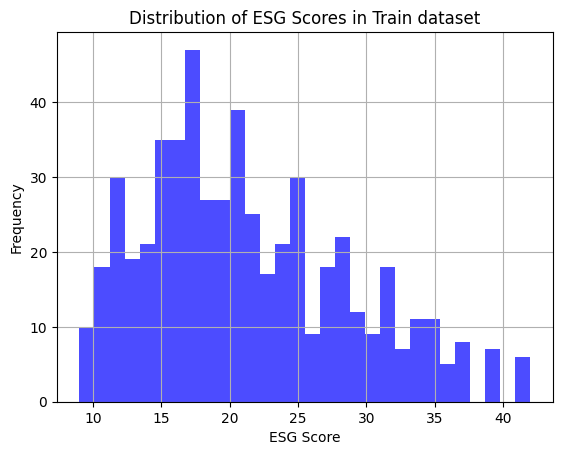

In [4]:
# Plotting the distribution of 'esg_score'
plt.figure()
plt.hist(train['esg_score'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of ESG Scores in Train dataset')
plt.xlabel('ESG Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [13]:
test.head()

,symbol,year,quarter,transcript_esg,esg_score,esg_risk_level,esg_score_pred,esg_risk_level_pred
0,ADP,2022,1,call reference nongaap financial measures beli...,14.0,Low,17.771372,Low
1,ADP,2022,1,call reference nongaap financial measures beli...,14.0,Low,17.771372,Low
2,ADSK,2022,1,addition replay call available autodeskcominve...,16.0,Negligible,15.436060,Low
3,ADSK,2022,3,addition replay call available autodeskcominve...,16.0,Negligible,18.505587,Low
4,ADSK,2022,4,addition replay call available autodeskcominve...,16.0,Negligible,16.316555,Low


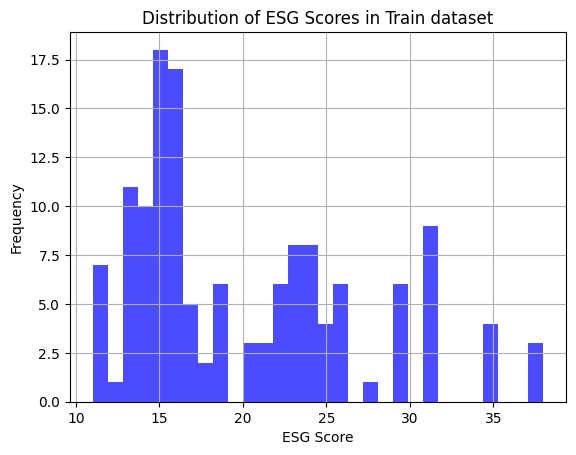

In [14]:
# Plotting the distribution of 'esg_score'
plt.figure()
plt.hist(test['esg_score'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of ESG Scores in Train dataset')
plt.xlabel('ESG Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Load model

In [6]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("checkpoints/bert_finetuned_240430_1359/checkpoint-760", num_labels=1)
model.to("cuda")

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### Inference

In [7]:
def get_results(df, batch_size=12, max_length=512):
    
    nb_batches = len(df) // batch_size + 1
    esg_score_pred = []

    for i in range(nb_batches):
        input_texts = list(df[i * batch_size: (i+1) * batch_size]["transcript_esg"])
        encoded = tokenizer(input_texts, truncation=True, padding="max_length", max_length=max_length, return_tensors="pt").to("cuda")
        esg_score_pred += model(**encoded).logits.reshape(-1).tolist()
    
    df["esg_score_pred"] = esg_score_pred
    
    return df

In [8]:
get_results(train)

,symbol,year,quarter,transcript_esg,esg_score,esg_risk_level,esg_score_pred,esg_risk_level_pred
0,A,2022,1,thank emily welcome everyone agilents conferen...,15.0,Low,14.574253,Low
1,A,2022,3,thank hannah welcome everyone agilents confere...,15.0,Low,20.206284,Medium
2,AAPL,2022,1,good day welcome apple q fy earnings conferenc...,17.0,Low,16.495562,Low
3,AAPL,2022,2,good day welcome apple q fy earnings conferenc...,17.0,Low,16.519716,Low
4,AAPL,2022,3,good day welcome apple q fy earnings conferenc...,17.0,Low,16.715889,Low
...,...,...,...,...,...,...,...,...
542,WMT,2023,3,followed questionandanswer session turn call d...,25.0,Medium,25.218025,Medium
543,YUM,2022,1,welcome q yum brand earnings conference call n...,21.0,Medium,21.198875,Medium
544,YUM,2022,2,get started would like remind conference call ...,21.0,Medium,21.687849,Medium
545,ZTS,2022,1,thank operator good morning everyone welcome z...,18.0,Low,16.870632,Low


In [15]:
mean_squared_error(train.esg_score, train.esg_score_pred)

6.103754178532756

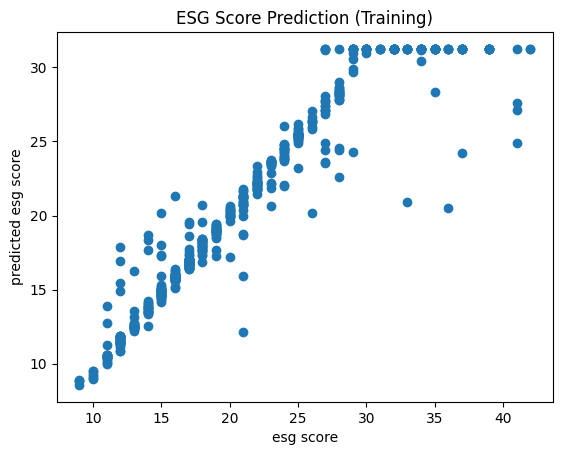

In [9]:
plt.scatter(
    x=train.esg_score,
    y=train.esg_score_pred,
)
plt.xlabel("esg score")
plt.ylabel("predicted esg score")
plt.title("ESG Score Prediction (Training)")
plt.show()

In [10]:
get_results(test)

,symbol,year,quarter,transcript_esg,esg_score,esg_risk_level,esg_score_pred,esg_risk_level_pred
0,ADP,2022,1,call reference nongaap financial measures beli...,14.0,Low,17.771372,Low
1,ADP,2022,1,call reference nongaap financial measures beli...,14.0,Low,17.771372,Low
2,ADSK,2022,1,addition replay call available autodeskcominve...,16.0,Negligible,15.436060,Low
3,ADSK,2022,3,addition replay call available autodeskcominve...,16.0,Negligible,18.505587,Low
4,ADSK,2022,4,addition replay call available autodeskcominve...,16.0,Negligible,16.316555,Low
...,...,...,...,...,...,...,...,...
133,VRTX,2022,2,reshma kewalramani vertexs ceo president stuar...,23.0,Medium,25.099281,Medium
134,VRTX,2022,3,reshma kewalramani vertexs ceo president stuar...,23.0,Medium,25.244778,Medium
135,XRAY,2022,1,begin let start im excited took role interim c...,16.0,Negligible,21.017057,Medium
136,XYL,2022,2,good morning everyone welcome xylems second qu...,16.0,Negligible,18.315838,Low


In [16]:
mean_squared_error(test.esg_score, test.esg_score_pred)

29.301378926176834

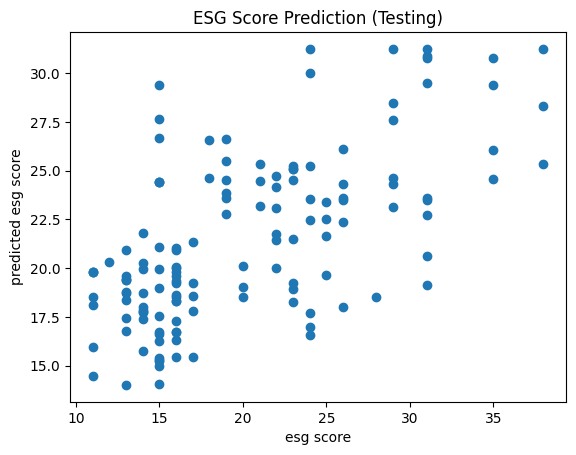

In [11]:
plt.scatter(
    x=test.esg_score,
    y=test.esg_score_pred,
)
plt.xlabel("esg score")
plt.ylabel("predicted esg score")
plt.title("ESG Score Prediction (Testing)")
plt.show()